# DATA LOADING

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns
import random
import cv2
import copy
import os
from sklearn.model_selection import train_test_split
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.models as models
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
import torchvision.transforms as transform
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from PIL import Image

from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
 
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [2]:
path = './chest_xray/chest_xray'

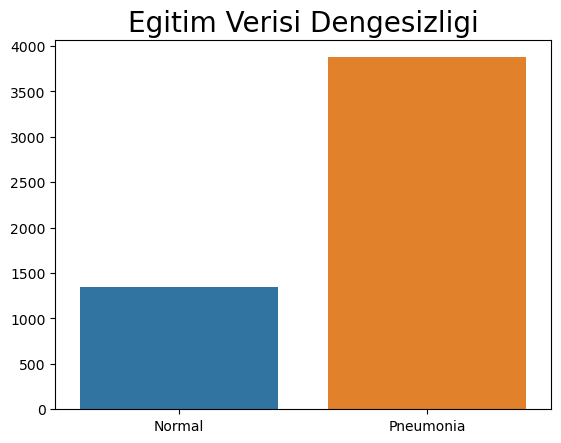

In [3]:
# Data Distrubition
train_samplesize = pd.DataFrame.from_dict(
    {'Normal': [len([os.path.join(path+'/train/NORMAL', filename) 
                     for filename in os.listdir(path+'/train/NORMAL')])], 
     'Pneumonia': [len([os.path.join(path+'/train/PNEUMONIA', filename) 
                        for filename in os.listdir(path+'/train/PNEUMONIA')])]})


sns.barplot(data=train_samplesize).set_title('Data Dİstrubition', fontsize=20)
plt.show()

# DATA AUGMENTATION

In [4]:
# Data Augmentation
# Handling class imbalance -> oversample the minority class ('Normal') by generating 1193 synthetic samples
# Zatürre - Normal = 2534
# 2534 - 1341 = 1193 
# Apply unique augmentation to make data diverse and prevent duplication

transformer = {
    'dataset1': transform.Compose([transform.Resize(255),
                                            transform.CenterCrop(224),
                                            transform.RandomHorizontalFlip(),
                                            transform.RandomRotation(10),
                                            transform.RandomGrayscale(),
                                            transform.RandomAffine(translate=(0.05,0.05), degrees=0),
                                            transform.ToTensor()
                                           ]),
    
    'dataset2' : transform.Compose([transform.Resize(255),
                                            transform.CenterCrop(224),
                                            transform.RandomHorizontalFlip(p=1),
                                            transform.RandomGrayscale(),
                                            transform.RandomAffine(translate=(0.1,0.05), degrees=10),
                                            transform.ToTensor()
                                    
                                           ]),
    'dataset3' : transform.Compose([transform.Resize(255),
                                            transform.CenterCrop(224),
                                            transform.RandomHorizontalFlip(p=0.5),
                                            transform.RandomRotation(15),
                                            transform.RandomGrayscale(p=1),
                                            transform.RandomAffine(translate=(0.08,0.1), degrees=15),
                                            transform.ToTensor()
                                           ]),
}

In [5]:
dataset1 = ImageFolder(path+'/train', 
                      transform=transformer['dataset1'])

dataset2 = ImageFolder(path+'/train', 
                      transform=transformer['dataset2'])

dataset3 = ImageFolder(path+'/train', 
                      transform=transformer['dataset3'])

norm1, _ = train_test_split(dataset2, test_size= 3875/(1341+3875), shuffle=False)
norm2, _ = train_test_split(dataset3, test_size= 4023/(1341+3875), shuffle=False)

dataset = ConcatDataset([dataset1, norm1, norm2])

print(len(dataset))

7750


In [6]:
print(dataset1.classes)

['NORMAL', 'PNEUMONIA']


In [7]:
def plot_samples(samples):  
    fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(30,8))
    for i in range(len(samples)):
        image = cv2.cvtColor(imread(samples[i]), cv2.COLOR_BGR2RGB)
        ax[i//5][i%5].imshow(image)
        if i<5:
            ax[i//5][i%5].set_title("Normal", fontsize=20)
        else:
            ax[i//5][i%5].set_title("Pneumonia", fontsize=20)
        ax[i//5][i%5].axis('off')

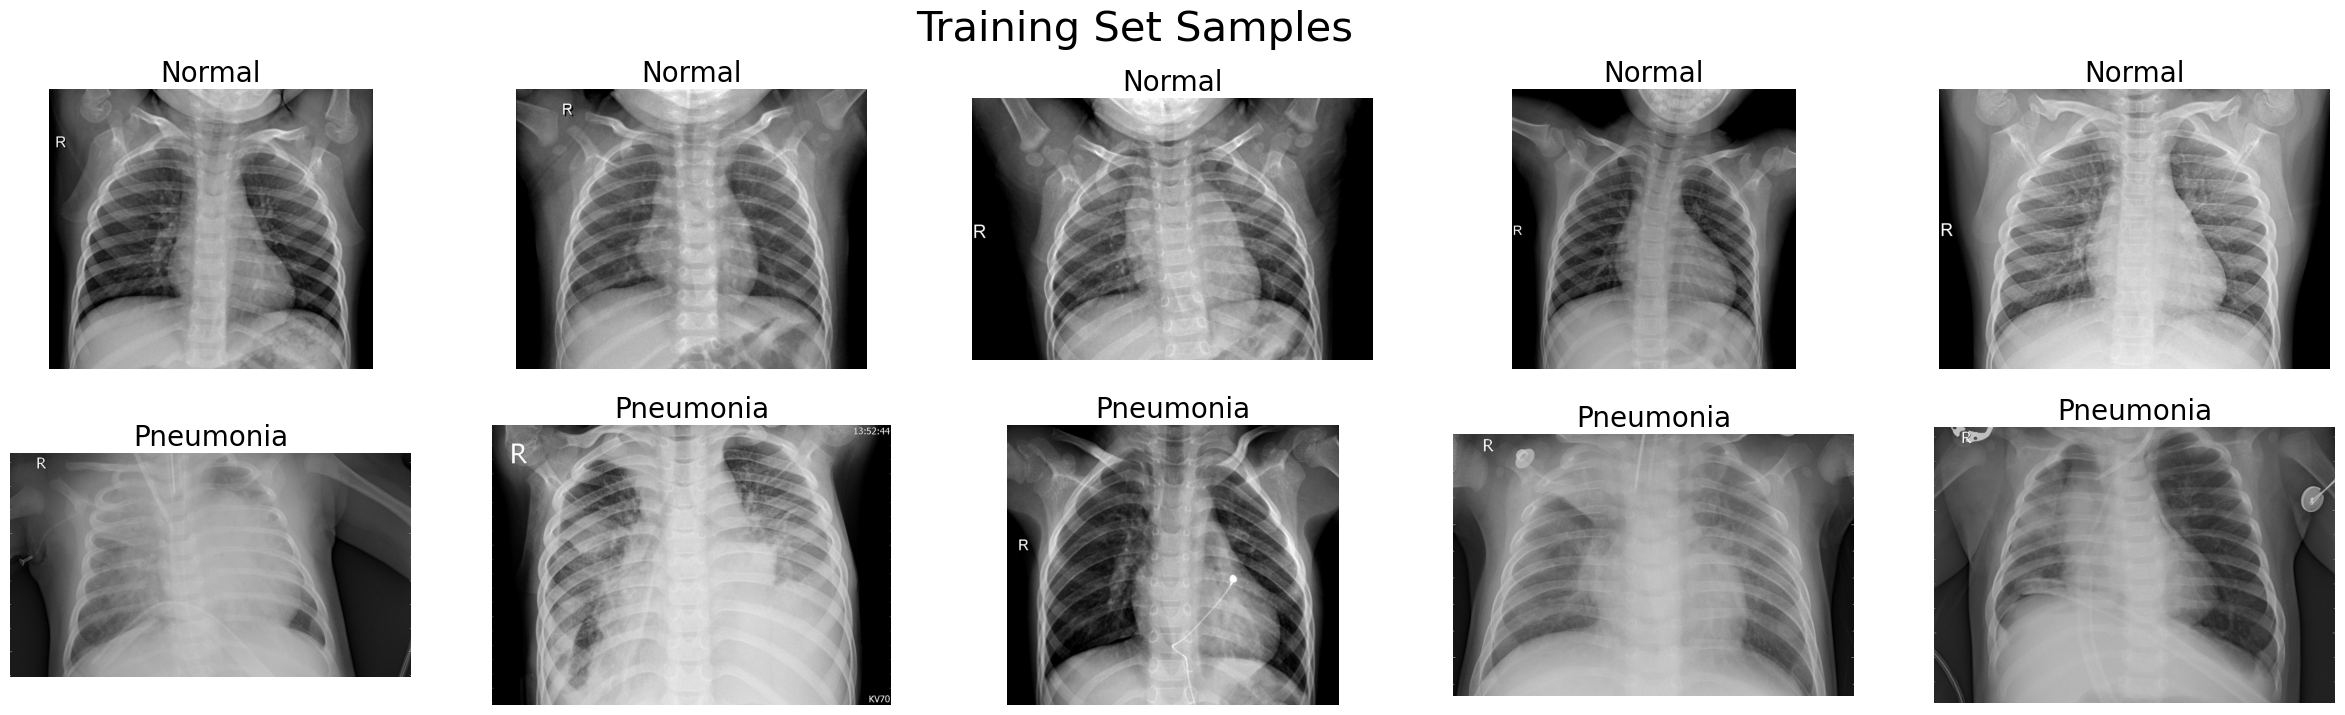

In [8]:
rand_samples = random.sample([os.path.join(path+'/train/NORMAL', filename) 
                              for filename in os.listdir(path+'/train/NORMAL')], 5) + \
    random.sample([os.path.join(path+'/train/PNEUMONIA', filename) 
                   for filename in os.listdir(path+'/train/PNEUMONIA')], 5)

plot_samples(rand_samples)
plt.suptitle('Training Set Samples', fontsize=30)
plt.show()

# Train & Validation Split

In [9]:
random_seed = 2020
torch.manual_seed(random_seed);

In [10]:
train_ds, val_ds = train_test_split(dataset, test_size=0.3, random_state=random_seed)
len(train_ds), len(val_ds)

(5425, 2325)

In [11]:
# Data Loaders

batch_size=20

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

loaders = {'train':train_dl, 'val':val_dl}
dataset_sizes = {'train':len(train_ds), 'val':len(val_ds)}

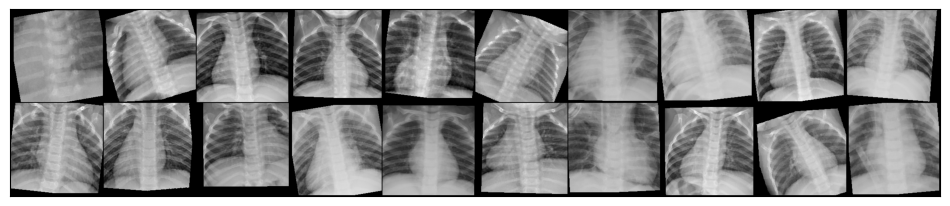

In [12]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:60], nrow=10).permute(1, 2, 0))
        break
        
show_batch(train_dl)

# DenseNet Model Initialization

In [13]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1) 
    return torch.tensor(torch.sum(preds == labels).item() / len(preds)), preds

In [14]:
from torchvision.models import DenseNet161_Weights

model = torchvision.models.densenet161(weights=DenseNet161_Weights.DEFAULT)

In [15]:
# Transfer Learning

for param in model.parameters():
    param.requires_grad = False 
    
in_features = model.classifier.in_features

model.classifier = nn.Linear(in_features, 2) 

In [16]:
losses = {'train':[], 'val':[]}
accuracies = {'train':[], 'val':[]}

# Model Training

In [17]:
# Executes training loop, evaluates validation metrics, updates LR, saves the best model weights

def train(model, criterion, optimizer, scheduler, epochs):
  since = time.time() 
  best_model = copy.deepcopy(model.state_dict()) 
  best_acc = 0.0
    
  for epoch in range(epochs):
    for phase in ['train', 'val']:
      if phase == 'train': 
        model.train()
      else:
        model.eval()
      
      running_loss = 0.0
      running_corrects = 0.0

      for inputs, labels in loaders[phase]: 
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        with torch.set_grad_enabled(phase=='train'): # forward pass
          outp = model(inputs)
          _, pred = torch.max(outp, 1)
          loss = criterion(outp, labels)
        
          if phase == 'train': # backward pass
            loss.backward()
            optimizer.step()
        
        running_loss += loss.item()*inputs.size(0)
        running_corrects += torch.sum(pred == labels.data)


      epoch_loss = running_loss / dataset_sizes[phase]
      epoch_acc = running_corrects.double()/dataset_sizes[phase]
      losses[phase].append(float(epoch_loss)) 
      accuracies[phase].append(epoch_acc.cpu().item())
        
      if phase == 'train':
        print('Epoch: {}/{}'.format(epoch+1, epochs))
      print('{} - loss:{}, accuracy{}'.format(phase, epoch_loss, epoch_acc))
    
      if phase == 'val':
        print('Time: {}m {}s'.format((time.time()- since)//60, (time.time()- since)%60))
            
      if phase == 'val' and epoch_acc.cpu().item() > best_acc:
        best_acc = epoch_acc.cpu().item()
        best_model = copy.deepcopy(model.state_dict())
          
    scheduler.step()  
      
  time_elapsed = time.time() - since
  print('Training Time {}m {}s'.format(time_elapsed//60, time_elapsed%60)) 
  print('Best accuracy {}'.format(best_acc))

  model.load_state_dict(best_model)
  return model   

In [18]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.classifier.parameters(), lr = 0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 4, gamma=0.1)

In [19]:
model.to(device)
epochs = 10
model = train(model, criterion, optimizer, scheduler, epochs)

Epoch: 1/10
train - loss:0.2842797315271769, accuracy0.8934562211981567
val - loss:0.14429560644972708, accuracy0.9526881720430107
Time: 0.0m 44.1458854675293s
Epoch: 2/10
train - loss:0.16819917265377288, accuracy0.9343778801843318
val - loss:0.1607811454403144, accuracy0.9359139784946237
Time: 1.0m 28.469252347946167s
Epoch: 3/10
train - loss:0.14817162061341896, accuracy0.9469124423963133
val - loss:0.10891911010508255, accuracy0.9587096774193549
Time: 2.0m 12.912911891937256s
Epoch: 4/10
train - loss:0.13766305069632245, accuracy0.9458064516129032
val - loss:0.11420825393169477, accuracy0.9574193548387097
Time: 2.0m 57.085411071777344s
Epoch: 5/10
train - loss:0.11278281307989552, accuracy0.9587096774193549
val - loss:0.10068114179997675, accuracy0.963010752688172
Time: 3.0m 41.21334671974182s
Epoch: 6/10
train - loss:0.108195406692918, accuracy0.9635023041474654
val - loss:0.11067745688381375, accuracy0.9565591397849462
Time: 4.0m 25.6927011013031s
Epoch: 7/10
train - loss:0.11501

In [20]:
for param in model.parameters():
    param.requires_grad = True
    
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)

model.to(device)
grad_clip = None
weight_decay = 1e-4

epochs = 10
model = train(model, criterion, optimizer, scheduler, epochs)

Epoch: 1/10
train - loss:0.1066201546536823, accuracy0.9631336405529954
val - loss:0.2616838700668786, accuracy0.9243010752688172
Time: 1.0m 46.346413373947144s
Epoch: 2/10
train - loss:0.06633116466713176, accuracy0.975668202764977
val - loss:0.08812331616558054, accuracy0.9711827956989247
Time: 3.0m 33.56075406074524s
Epoch: 3/10
train - loss:0.027319905989372048, accuracy0.9902304147465438
val - loss:0.05170795082925789, accuracy0.9789247311827957
Time: 5.0m 20.801326751708984s
Epoch: 4/10
train - loss:0.0159408866686348, accuracy0.9952073732718894
val - loss:0.052344055362145904, accuracy0.9853763440860215
Time: 7.0m 8.158148765563965s
Epoch: 5/10
train - loss:0.017539298113134854, accuracy0.9955760368663594
val - loss:0.033416918197005825, accuracy0.9883870967741936
Time: 8.0m 55.338538646698s
Epoch: 6/10
train - loss:0.0023956186856078764, accuracy0.9990783410138249
val - loss:0.04499899708488781, accuracy0.9879569892473118
Time: 10.0m 42.32179045677185s
Epoch: 7/10
train - loss:

In [21]:
torch.save(model.state_dict(), 'best_chest_xray_densenet.pth')
print("Model agirliklari kaydedildi.")

Model agirliklari kaydedildi.


In [22]:
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = checkpoint['model']
    model.load_state_dict(checkpoint['state_dict'])
    for parameter in model.parameters():
        parameter.requires_grad = False

    model.eval()
    return model

model = load_checkpoint('./PneumoniaResnet.pth')

epochs değişkeni: 10
train_accs: 20 val_accs: 20 epoch_list: 20


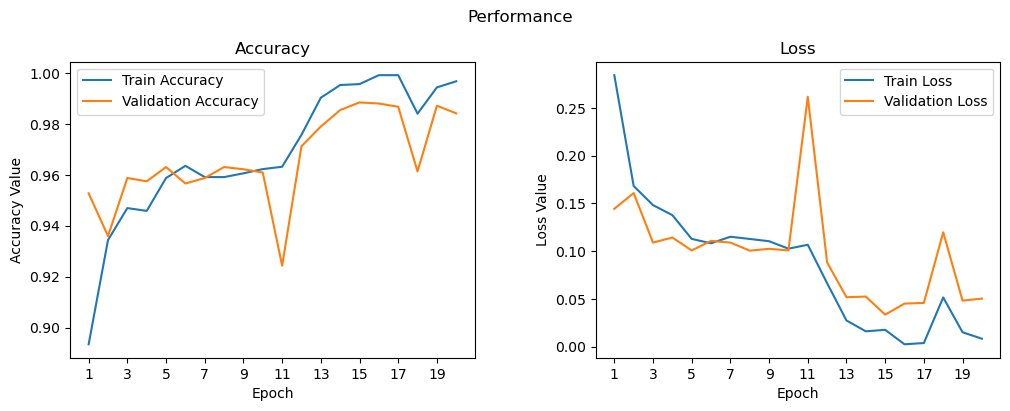

In [23]:
# Accuracy ve Loss Visualization 

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

def to_scalar(x):
    if torch.is_tensor(x):
        return x.detach().cpu().item()
    return float(x)

train_accs = [to_scalar(x) for x in accuracies['train']]
val_accs   = [to_scalar(x) for x in accuracies['val']]
train_losses = [float(x) for x in losses['train']]
val_losses   = [float(x) for x in losses['val']]

epoch_list = list(range(1, len(train_accs) + 1))

print("epochs değişkeni:", epochs)
print("train_accs:", len(train_accs), "val_accs:", len(val_accs), "epoch_list:", len(epoch_list))

# Graphic 1: Accuracy
ax1.plot(epoch_list, train_accs, label='Train Accuracy')
ax1.plot(epoch_list, val_accs, label='Validation Accuracy')
ax1.set_xticks(np.arange(1, len(epoch_list)+1, max(1, len(epoch_list)//10)))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
ax1.legend(loc="best")

# Graphic 2: Loss
ax2.plot(epoch_list, train_losses, label='Train Loss')
ax2.plot(epoch_list, val_losses, label='Validation Loss')
ax2.set_xticks(np.arange(1, len(epoch_list)+1, max(1, len(epoch_list)//10)))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
ax2.legend(loc="best")

plt.show()


# TEST

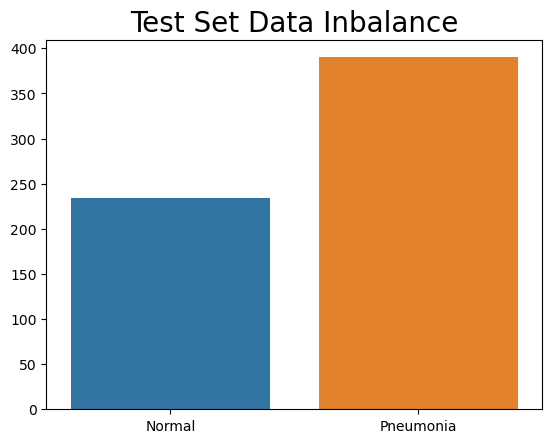

In [24]:
test_samplesize = pd.DataFrame.from_dict(
    {'Normal': [len([os.path.join(path+'/test/NORMAL', filename) 
                     for filename in os.listdir(path+'/test/NORMAL')])], 
     'Pneumonia': [len([os.path.join(path+'/test/PNEUMONIA', filename) 
                        for filename in os.listdir(path+'/test/PNEUMONIA')])]})

sns.barplot(data=test_samplesize).set_title('Test Set Data Inbalance', fontsize=20)
plt.show()

In [25]:
def validation_step(batch):
        images,labels = batch
        images,labels = images.to(device),labels.to(device)
        out = model(images) # Forward pass                                     
        loss = F.cross_entropy(out, labels) # Loss                   
        acc,preds = accuracy(out, labels) # Accuracy                      
        
        return {'val_loss': loss.detach(), 'val_acc':acc.detach(), 
                'preds':preds.detach(), 'labels':labels.detach()}

In [26]:
def test_prediction(outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()           
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()             
        batch_preds = [pred for x in outputs for pred in x['preds'].tolist()] 
        batch_labels = [lab for x in outputs for lab in x['labels'].tolist()]  
        
        return {'test_loss': epoch_loss.item(), 'test_acc': epoch_acc.item(),
                'test_preds': batch_preds, 'test_labels': batch_labels}  

In [27]:
@torch.no_grad()
def test_predict(model, test_loader):
    model.eval()
    outputs = [validation_step(batch) for batch in test_loader] 
    results = test_prediction(outputs)                          
    print('test_loss: {:.4f}, test_acc: {:.4f}'
          .format(results['test_loss'], results['test_acc']))
    
    return results['test_preds'], results['test_labels']

In [28]:
testset = ImageFolder(path+'/test', 
                           transform=transform.Compose([transform.Resize(255),
                                                 transform.CenterCrop(224),                                                              
                                                 transform.ToTensor(),
                                                ]))

In [29]:
test_dl = DataLoader(testset, batch_size=256)
model.to(device)
preds,labels = test_predict(model, test_dl)

test_loss: 0.4729, test_acc: 0.9280


# Confusion Matrix

<Figure size 640x480 with 0 Axes>

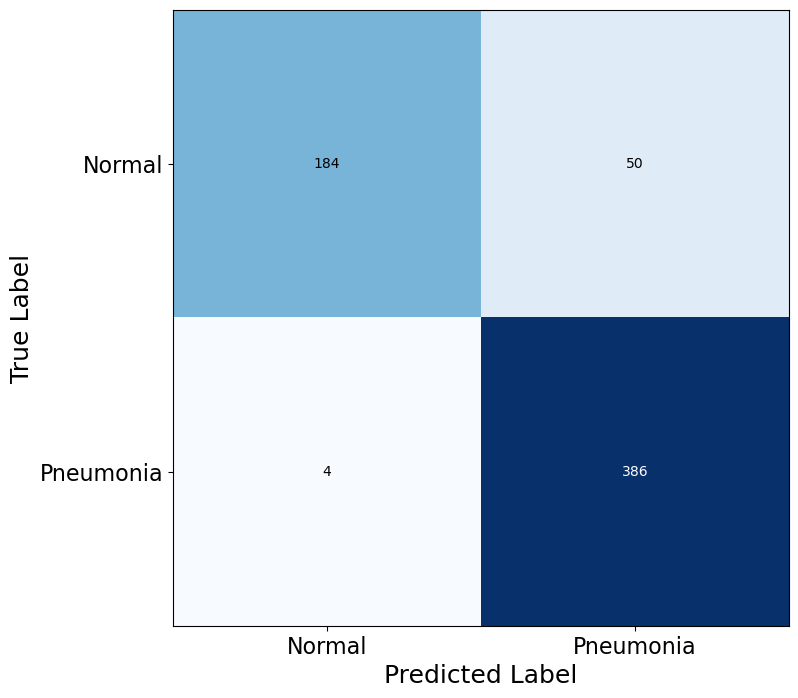

In [30]:
cm  = confusion_matrix(labels, preds)
plt.figure()
plot_confusion_matrix(cm,figsize=(12,8),cmap=plt.cm.Blues)
plt.xticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.yticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.xlabel('Predicted Label',fontsize=18)
plt.ylabel('True Label',fontsize=18)
plt.show()

In [31]:
# Accuracy, recall, recision ve f1 score 

tn, fp, fn, tp = cm.ravel()

accuracy = (np.array(preds) == np.array(labels)).sum() / len(preds)
precision = tp/(tp+fp)
recall = tp/(tp+fn)
f1 = 2*((precision*recall)/(precision+recall))

print("Accuracy of the model is {:.2f}".format(accuracy))
print("Recall of the model is {:.2f}".format(recall))
print("Precision of the model is {:.2f}".format(precision))
print("F1 Score of the model is {:.2f}".format(f1))

Accuracy of the model is 0.91
Recall of the model is 0.99
Precision of the model is 0.89
F1 Score of the model is 0.93


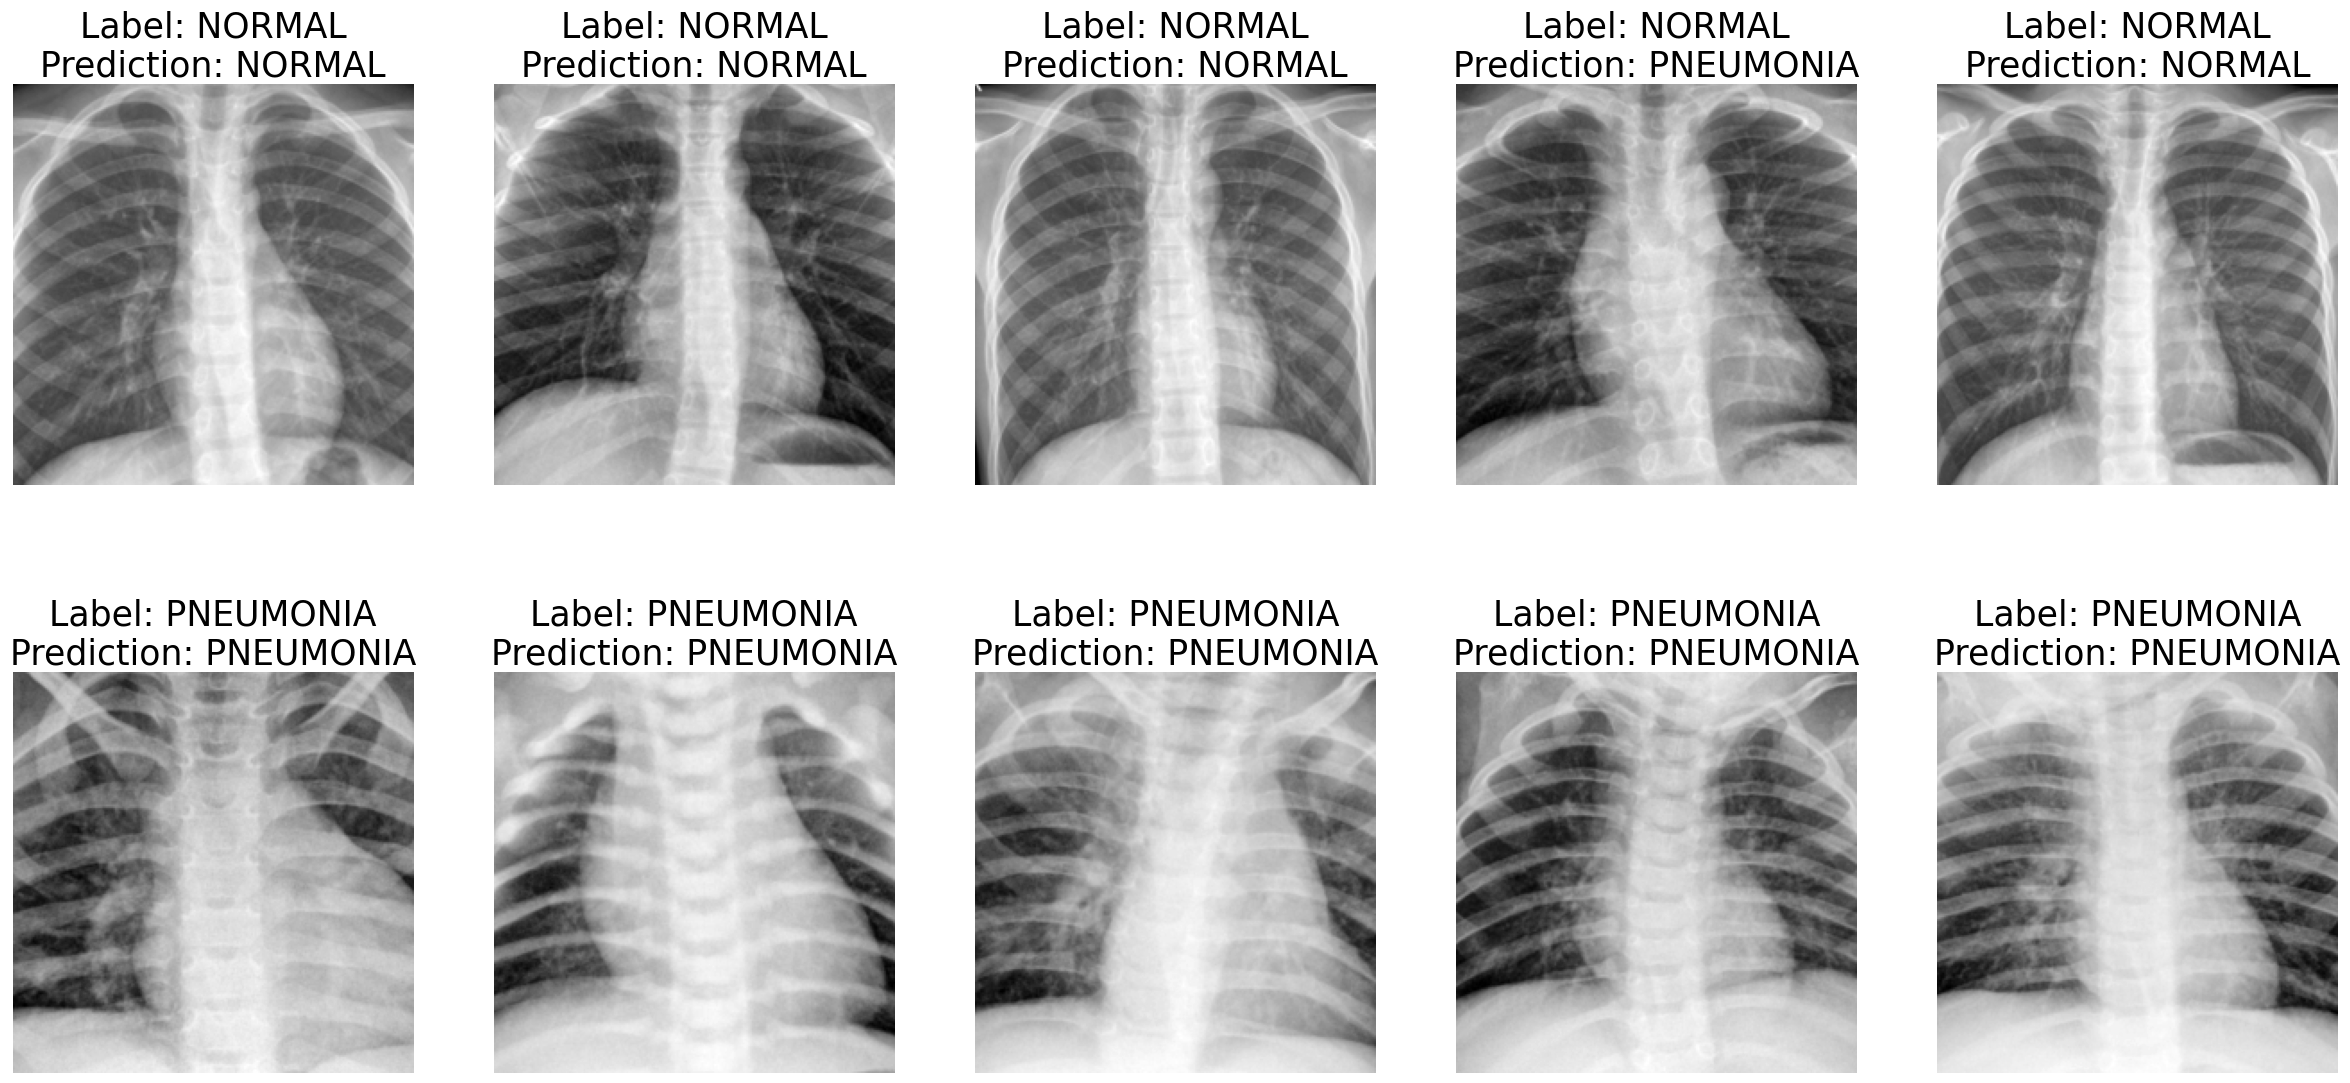

In [32]:
idxs = torch.tensor(np.append(np.arange(start=0, stop=5, step=1), 
                             np.arange(start=500, stop=505, step=1))) 

fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(30,14))

for c,i in enumerate(idxs):
    img_tensor, label = testset[i]
    ax[c//5][c%5].imshow(img_tensor[0,:,:], cmap='gray')
    ax[c//5][c%5].set_title('Label: {}\nPrediction: {}'
                            .format(testset.classes[label], 
                                    testset.classes[preds[i]]),
                            fontsize=25)
    ax[c//5][c%5].axis('off')

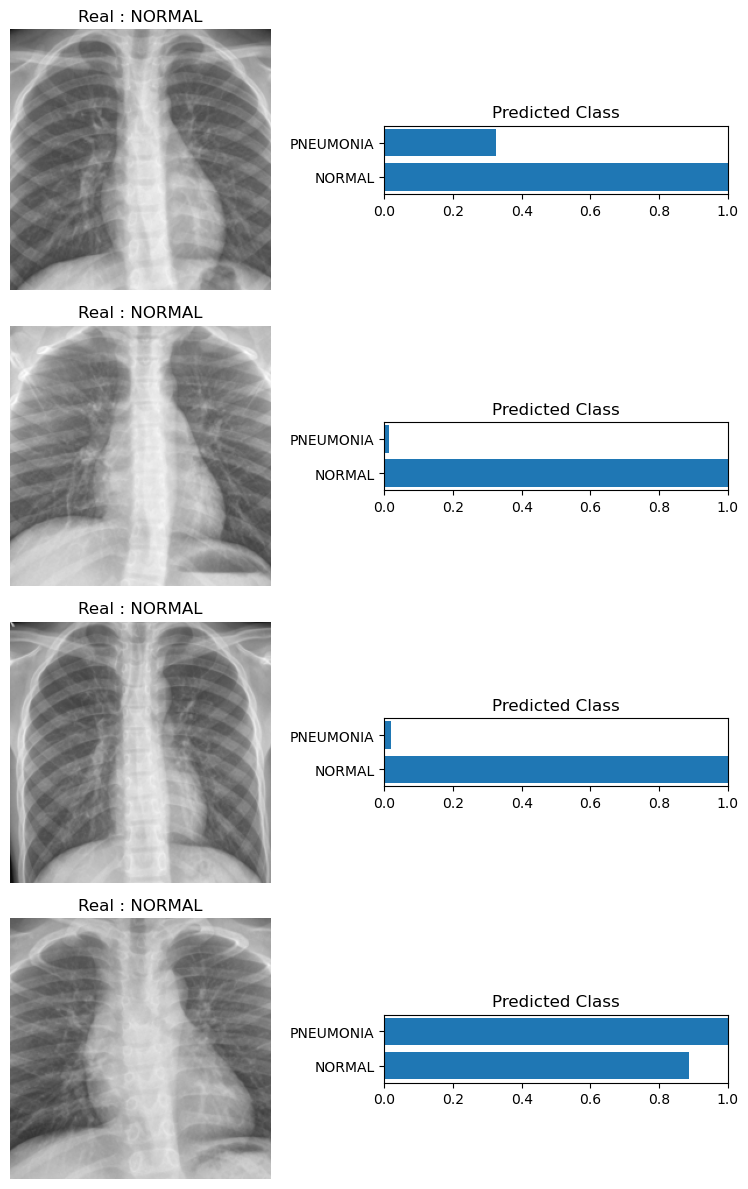

In [33]:
fig, ax = plt.subplots(figsize=(8,12), ncols=2, nrows=4)

for row in range(4):
    img,label = testset[row]
    pred = torch.exp(model(img.to(device).unsqueeze(0)))
    class_name = ['NORMAL', 'PNEUMONIA']
    classes = np.array(class_name)
    pred = pred.cpu().data.numpy().squeeze()
    ax[row][0].imshow(img.permute(1, 2, 0))
    ax[row][0].set_title('Real : {}'.format(class_name[label]))
    ax[row][0].axis('off')
    ax[row][1].barh(classes, pred)
    ax[row][1].set_aspect(0.1)
    ax[row][1].set_yticks(classes)
    ax[row][1].set_yticklabels(classes)
    ax[row][1].set_title('Predicted Class')
    ax[row][1].set_xlim(0, 1.)
    plt.tight_layout()